[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)

In [1]:
import os, sys

os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from functools import partial
import math
import timeit
import numpy as np, scipy
from scipy.optimize import elementwise
from matplotlib import pyplot
from collections import namedtuple, defaultdict
# 
# import os
# os.environ['NUMBA_DISABLE_JIT']='1'
import numba

from open_atmos_jupyter_utils import show_plot
from PySDM import physics
from PySDM_examples.Grabowski_and_Pawlowska_2023.settings import DRY_SPECTRA
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.physics.dimensional_analysis import DimensionalAnalysis
from PySDM.backends.impl_numba.toms748 import toms748_solve
from PySDM.backends.impl_numba.warnings import warn


# import warnings
# warnings.filterwarnings("error")

In [3]:
n_sd=2**2 # TEMP 2**10
commons = {
    'kappa': 1.28,
    'init_temperature_K': 300,
    'init_dry_pressure_Pa': 100000,
    'total_water_mixing_ratio': 21.5/1000,
    't_max_s': 300, # TEMP!
}
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

In [4]:
formulae = make_namedtuple("F", {
    # eq. (1) in the NPG paper
    "drw_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the NPG paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13) in the NPG paper
    "dpd_dt": lambda c, rhod, w: -rhod * c.g * w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    "dthd_dt": lambda c, T, thd, rhod, dqv_dt: -c.l_v * dqv_dt / c.cp_d / T * thd * rhod,

    # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    "thd": lambda c, T, pd: T * np.power(c.p1000 / pd, c.R_d / c.cp_d),
    "T": lambda c, θd, ρd: θd * (ρd * θd / c.p1000 * c.R_d)**(c.R_d/c.cp_d / (1 - c.R_d/c.cp_d)),
    "pd": lambda c, T, ρd: c.R_d * T * ρd,
    "pv": lambda c, qt, T, rhod: qt * c.R_v * T * rhod,

    "RH": lambda c, ml, rho_vs, rhod: rhod * (c.qt - ml / c.m_d) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * np.dot(c.xi * rw**2, drw_dt) / c.m_d * c.rho_w,
    "w": lambda c, t: c.w_mean * np.pi / 2 * np.sin(np.pi * t * c.w_mean / c.z_half),
    "z": lambda c, t: c.z_half / 2 * (1 - np.cos(np.pi * t * c.w_mean / c.z_half)),
    "r_c": lambda c, rd: (3 * c.κ * rd**3 / c.A)**.5,
    "ml": lambda c, rw, xi: (xi @ rw**3) * 4/3 * np.pi * c.rho_w,
    "ml_scalar": lambda c, rw, xi: rw**3 * xi * 4/3 * np.pi * c.rho_w,
    
    # size variable:    
    "rw": lambda c, x: c.r0 * np.exp(x),
    "x": lambda c, rw: np.log(rw / c.r0), 
    "drw_dx": lambda rw : rw,
})

In [5]:
def ode_jacobian(c, rw, T, w):
    Jxx = np.diag(-2 / rw**2) - 4 * np.pi * D / rhod / md * np.multiply.outer(1 / rw**2, xi * rw**3)
    Jxp = D / rho_w / rw**2 / c.Rd / T * (qt - ml/md)
    JxT = 0 #
    Jpx = 0 #
    Jpp = - 1 / c.Rd / T * c.g * w
    JpT = 0 #
    JTx = 0 #
    JTp = 0 #
    JTT = 0 #

In [6]:
def constants(*, n_sd, aerosol, total_water_mixing_ratio, t_max_s, w_multiplier, kappa):
    r_dry, multiplicities = ConstantMultiplicity(DRY_SPECTRA[aerosol][kappa]).sample_deterministic(n_sd)
    ix = make_namedtuple("I", {
        "x": slice(0, n_sd),
        "pd": n_sd,
        "T": n_sd + 1,
        "size": n_sd + 2
    })
    
    SI = physics.si
    M_a = 0.029 * SI.kg / SI.mole
    M_v = 0.018 * SI.kg / SI.mole
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    constants = make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,
        "p1000": 1000 * SI.hPa,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "r0": SI.nm,
        "κ": kappa,
        "rd": r_dry * SI.m,
        "xi": multiplicities,
        "m_d": 1 * SI.kg,
        "qt": total_water_mixing_ratio,
        "t_max": t_max_s * SI.s,
        "w_mean": w_multiplier * SI.m / SI.s,
        "z_half": 150 * SI.m, #TEMP
        "ix": ix,
    })
    return constants, SI

def initial_condition(SI, c, init_dry_pressure_Pa, init_temperature_K,):
    RH = formulae.RH(c,
                 ml=0,
                 rho_vs=formulae.rhov(c, pv=formulae.pvs(c, init_temperature_K), T=init_temperature_K),
                 rhod=formulae.rhod(c, pd=init_dry_pressure_Pa, T=init_temperature_K)
                )
    result = elementwise.find_root(
        lambda rw, rd: RH - formulae.RH_eq(c, rw, rd),
        (c.rd, formulae.r_c(c, c.rd)),
        args=(c.rd,)
    )
    assert all(result.success)

    y0 = [0] * c.ix.size
    y0[c.ix.pd] = init_dry_pressure_Pa * SI.Pa
    y0[c.ix.T] = init_temperature_K * SI.K
    y0[c.ix.x] = formulae.x(c, rw=result.x)
    
    return y0

In [7]:
jit_compile = numba.jit(error_model='numpy', fastmath=True)
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(t, y, c):
    rhod = jf.rhod(c, pd=y[c.ix.pd], T=y[c.ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[c.ix.T]), T=y[c.ix.T])
    rw = jf.rw(c, x=y[c.ix.x])  # TODO: we do not need to allocate this!
    ml = jf.ml(c, rw=rw, xi=c.xi)
    RH = jf.RH(c, ml=ml, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.rd)
    
    dy_dt = np.empty_like(y)
    dy_dt[c.ix.pd] = jf.dpd_dt(c, rhod=rhod, w=jf.w(c, t))
    dy_dt[c.ix.x] = jf.drw_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / jf.drw_dx(rw)
    dy_dt[c.ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[c.ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[c.ix.x] * jf.drw_dx(rw)), rhod=rhod)
    return dy_dt

In [8]:
# Bartman et al. adaptivity algorithm:
# - does not require additional state-vector-size memory
# - implicit-in-size/explicit-in-thermodynamics

@jit_compile
def adapt_substeps(step_impl_args, n_substeps, thd, rtol_thd): # TODO switch to rh
    """ calls `calculate_ml_new(fake=True) ... """

    
    return 1, True

@jit_compile
def minfun(x_new, c, ρv, rd, ρvs, x_old, dt):
    return (
        x_old
        - x_new
        + dt * jf.drw_dt(
            c, 
            rw=jf.rw(c, x=x_new),
            rho_v=ρv,
            rho_o=jf.RH_eq(c, rw=jf.rw(c, x=x_new), rd=rd) * ρvs
        ) / jf.drw_dx(rw=jf.rw(c, x=x_new))
    )

@jit_compile
def within_tol(error_estimate, value, rtol):
    return error_estimate < rtol * np.abs(value)


@jit_compile
def calculate_ml_new(c, x_old, x_new, dt, fake, ρv, ρvs, rtol_x):
    """ implicit Euler solution for drop sizes altering the 
    `x` argument if `fake` if False, otherwise returning the
    new liquid water mass without changing `x` """
    max_iters = 16

    ml_new = 0
    success = True
    for drop in range(len(c.rd)):
        x_insane = jf.x(c, rw=c.rd[drop] / 100**(1/3))
        # TODO: RH_tol
        args = c, ρv, c.rd[drop], ρvs, x_old[drop], dt
        dx_old = minfun(x_old[drop], *args)
        if dx_old == 0:
            x_root = x_old[drop]
        else: 
            a, b = x_old[drop], max(x_insane, x_old[drop] + dx_old)
            fa, fb = minfun(a, *args), minfun(b, *args)
            counter = 0
            while not fa * fb < 0:
                counter += 1
                if counter > max_iters:
                    if not fake:
                        warn("failed to find interval", __name__,
                            context=("a", a,  "b", b, "fa", fa, "fb", fb,),
                        )
                    success = False
                    break
                b = max(x_insane, a + math.ldexp(dx_old, counter))
                fb = minfun(b, *args)
            if not success:
                break
            if a != b:
                if a > b:
                    a, b = b, a
                    fa, fb = fb, fa
                x_root, iters_taken = toms748_solve(
                    minfun,
                    args,
                    a, b, fa, fb,
                    rtol=rtol_x, max_iter=max_iters, within_tolerance=within_tol
                )
                if iters_taken in (-1, max_iters):
                    if not fake:
                        warn("TOMS failed", __name__)
                    success = False
                    break
            else:
                x_root = x_old[drop]
        ml_new += jf.ml_scalar(c, rw=jf.rw(c, x=x_root), xi=c.xi[drop]) 
        if not fake:
            x_new[drop] = x_root
    return ml_new, success

@jit_compile
def step(c, x_old, x_new, qv, dqv_dt, θd, dθd_dt, ρd, dρd_dt, dt, n_substeps, fake, rtol_x):
    """ explicit (trapezoidal) integration of thermodynamics coupled
    with external implicit solver for drop sizes """
    dt /= n_substeps
    ml_old = jf.ml(c, rw=jf.rw(c, x=x_old), xi=c.xi)
    success = True
    assert n_substeps == 1 or not fake
    for _ in range(n_substeps):
        θd += dt * dθd_dt / 2
        qv += dt * dqv_dt / 2
        ρd += dt * dρd_dt / 2
        
        T = jf.T(c, θd=θd, ρd=ρd)
        ρvs_new = jf.rhov(c, pv=jf.pvs(c, T=T), T=T)
        ρv_new = jf.RH(c, ml=ml_old, rho_vs=ρvs_new, rhod=ρd) * ρvs_new
        ml_new, success_within_substep = calculate_ml_new(c, x_old, x_new, dt, fake, ρv_new, ρvs_new, rtol_x)
        dml_dt = (ml_new - ml_old) / dt
        
        dqv_dt_cond = -dml_dt / c.m_d
        dθd_dt_cond = jf.dthd_dt(c, T=T, thd=θd, rhod=ρd, dqv_dt=dqv_dt_cond)
        θd += dt * (dθd_dt / 2 + dθd_dt_cond)
        qv += dt * (dqv_dt / 2 + dqv_dt_cond)
        ρd += dt * dρd_dt / 2
        ml_old = ml_new
        if not fake:
            x_old[:] = x_new[:]
        success = success and success_within_substep
    return qv, θd, success

@jit_compile
def qθρ(c, pd, T, rw):
    ρd = jf.rhod(c, pd=pd, T=T)
    pvs = jf.pvs(c, T)
    RH = jf.RH(
        c,
        ml=jf.ml(c, rw=rw, xi=c.xi),
        rho_vs=jf.rhov(c, pv=pvs, T=T),
        rhod=ρd
    )
    return (
        jf.rhov(c, pv=RH * pvs, T=T) / ρd,
        jf.thd(c, T=T, pd=pd),
        ρd
    )

@jit_compile
def stepper(y, times, c, adaptive, rtol_thd, rtol_x):
    success = True
    n_substeps = 10
    
    for i in range(1, len(times)):
        pd_old = y[c.ix.pd, i-1]
        T_old = y[c.ix.T, i-1]
        rw_old = jf.rw(c, x=y[c.ix.x, i-1])
        qv_old, θd_old, ρd_old = qθρ(c, pd_old, T_old, rw_old)
        
        dpd_dt_old = jf.dpd_dt(c, rhod=ρd_old, w=jf.w(c, times[i-1]))
        dT_dt_old = jf.dT_dt(c, dpd_dt=dpd_dt_old, dqv_dt=0, rhod=ρd_old)

        dt = times[i] - times[i-1]
        pd_new =  pd_old + dt * dpd_dt_old
        T_new = T_old + dt * dT_dt_old
        
        qv_new, θd_new, ρd_new = qθρ(c, pd_new, T_new, rw_old)

        step_args = (
            c, y[c.ix.x, i-1], y[c.ix.x, i],
            qv_old, (qv_new - qv_old) / dt,
            θd_old, (θd_new - θd_old) / dt,
            ρd_old, (ρd_new - ρd_old) / dt,
        )
        if adaptive:
            n_substeps, success = adapt_substeps(step_args, n_substeps, θd_old, rtol_thd)
        if success:
            qv_new, θd_new, success = step(*step_args, dt, n_substeps, False, rtol_x)
        else:
            qv_new, θd_new, = np.nan, np.nan

        y[c.ix.T, i] = jf.T(c, θd=θd_new, ρd=ρd_new)
        y[c.ix.pd, i] = jf.pd(c, T=y[c.ix.T, i], ρd=ρd_new)
        
    return success

def adaptive_solver(*, t_span, y0, min_step, max_step, args, adaptive, rtol_thd, rtol_x):
    assert t_span[0] == 0  
    n_substeps_max = math.floor(t_span[1] / min_step)
    n_substeps_min = math.ceil(t_span[1] / max_step)
    
    y = np.empty(shape=(len(y0), n_substeps_min + 1))
    y[:, 0] = y0
    times = np.linspace(*t_span, y.shape[1], endpoint=True)
    success = stepper(y, times, args[0], adaptive, rtol_thd, rtol_x)
    return make_namedtuple("AS", {
        'success': success,
        'message': __name__,
        'y': y,
        't': times
    })

In [9]:
def run(n_sd, w_multiplier=np.nan, eps=np.nan, plot_spectrum=False):
    solutions = {}
    times = {}
    for aerosol in DRY_SPECTRA:
        solutions[aerosol] = {}
        times[aerosol] = {}
        c, SI = constants(
            n_sd=n_sd, 
            aerosol=aerosol,
            w_multiplier=w_multiplier,
            total_water_mixing_ratio=commons['total_water_mixing_ratio'],
            t_max_s=commons['t_max_s'],
            kappa=commons['kappa']
        )
        if plot_spectrum:
            pyplot.hist(np.log(c.rd), weights=c.xi, density=False, label=aerosol, alpha=.5)
        else:
            y0 = initial_condition(SI, c=c, init_dry_pressure_Pa=commons['init_dry_pressure_Pa'], init_temperature_K=commons['init_temperature_K'])
            for key, solver in {
                "our" : partial(adaptive_solver, adaptive=False, rtol_thd=1e-6, rtol_x=1e-6),
                "LSODA" : partial(scipy.integrate.solve_ivp, method='LSODA', atol=0, rtol=eps, fun=ode_rhs),
            }.items():
                solution = [None]
                def do(solution):
                    solution[0] = solver(
                        min_step=.5 / w_multiplier * SI.s,
                        t_span=(0, c.t_max / w_multiplier),
                        y0=y0,
                        max_step=.5 / w_multiplier * SI.s,
                        args=(c,),
                    )
                    assert solution[0].success, solution[0].message
                timer = timeit.Timer(partial(do, solution=solution))
                timer.timeit(number=1) # warmup (JIT, caches, ...)
                times[aerosol][key] = min(timer.repeat(repeat=1, number=1))
                solutions[aerosol][key]=solution[0]
    if plot_spectrum:
        pyplot.gca().set(ylabel="arbitrary unit", xlabel="log(dry radius / m)")
        pyplot.legend()
        show_plot("spectrum")
    else:
        return solutions, times

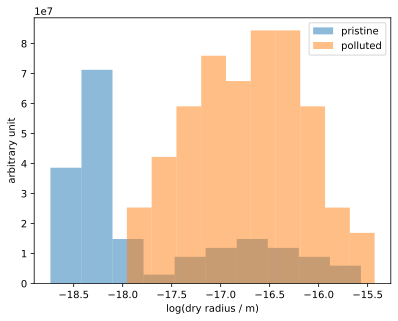

In [10]:
run(n_sd=2**6, plot_spectrum=True)

In [11]:
all_solutions = defaultdict(dict)
all_times = defaultdict(dict)

velocities_multiplier = (1, 0.5, 0.002)

for w_val in velocities_multiplier:
    solutions_w, times_w = run(n_sd, w_multiplier=w_val, eps=1e-3)
    
    for key, solution in solutions_w.items():
        all_solutions[key][w_val] = solution
        all_times[key][w_val] = times_w[key]

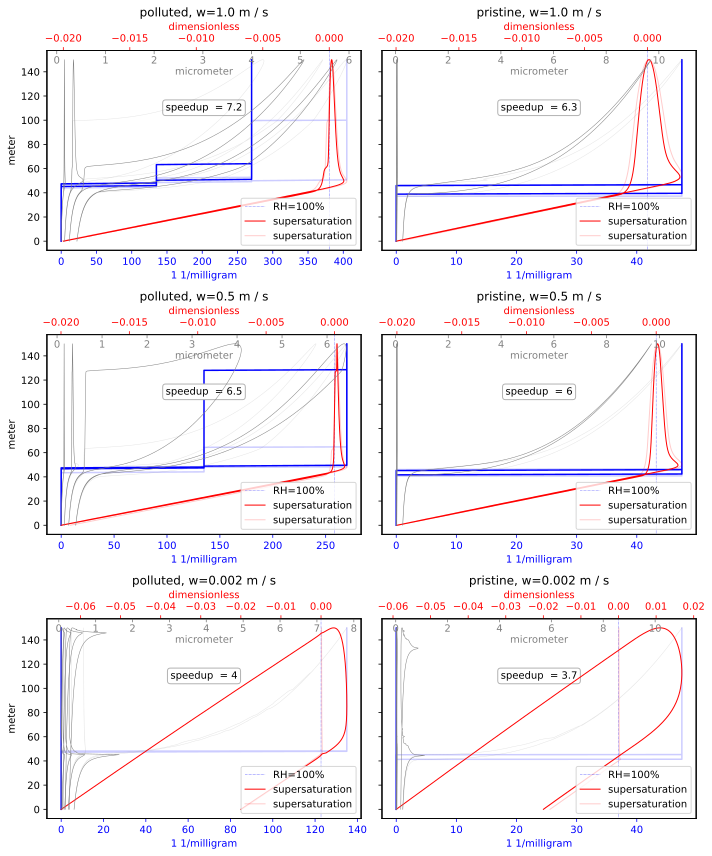

In [14]:
row_params = velocities_multiplier
columns = ["polluted", "pristine"]
methods_params = {"our": {"alpha": 1},
                  "LSODA": {"alpha": 0.2}
                  }

fig, axs = pyplot.subplots(
    nrows=len(row_params),
    ncols=len(columns),
    sharey=True,
    figsize=(10, 4*len(row_params)),
    tight_layout=True,
)
fig.subplots_adjust(hspace=0.5)


for i, param in enumerate(row_params):
    for j, aerosol in enumerate(columns):
        ax = axs[i, j]
        ax_s = ax.twiny()
        ax_r = ax.twiny()
        
        with DimensionalAnalysis():
            c, SI = constants(
                n_sd=n_sd, aerosol=aerosol,
                kappa=commons['kappa'],
                total_water_mixing_ratio=commons['total_water_mixing_ratio'],
                t_max_s=commons['t_max_s'],
                w_multiplier=param,
            )
            SI.setup_matplotlib()
            ax.set_title(f"{aerosol}, w={c.w_mean:~}")    
            ax.xaxis.set_units(1/SI.mg)
            ax_s.axvline(0, linestyle=':', color='blue', linewidth=0.5, label="RH=100%")
            ax_r.xaxis.set_units(SI.um) 
            
            for method, params in methods_params.items():
                solution = all_solutions[aerosol][param][method]
                
                t = solution.t * SI.s
                pd = solution.y[c.ix.pd]* SI.Pa
                T = solution.y[c.ix.T]* SI.K
                rw = formulae.rw(c, solution.y[c.ix.x])
                ml = formulae.ml(c, rw=rw, xi=c.xi)

                RH = formulae.RH(
                    c,
                    ml=ml,
                    rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                    rhod=formulae.rhod(c, pd=pd, T=T)
                )
                ax_s.plot(RH - 1, formulae.z(c, t), color='red', linewidth=1, label="supersaturation", alpha=params["alpha"])
                   
                for idx in range(c.ix.x.start, c.ix.x.stop):
                    ax_r.plot(rw[idx], formulae.z(c, t), color='gray', linewidth=.5, alpha=params["alpha"])
                n_activated = (
                        (rw > formulae.r_c(c, c.rd)[:, None])
                        * c.xi[:, None]
                ).sum(axis=0)
                ax.plot(n_activated / c.m_d, formulae.z(c, t), color='blue', linewidth=1.5, alpha=params["alpha"])

            speedup = all_times[aerosol][param]["LSODA"] / all_times[aerosol][param]["our"]
            ax.annotate(
                f"speedup  = {speedup:.2g}",
                xy=(0.5, 0.7),
                xycoords="axes fraction",
                ha="center",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    fc="white",
                    ec="0.7",
                    lw=1,
                )
            )       
            
        d_color = 'blue'
        ax.tick_params(axis='x', colors=d_color)
        ax.xaxis.label.set_color(d_color)    
        
        s_color = 'red'
        ax_s.tick_params(axis='x', colors=s_color, labelcolor=s_color)
        ax_s.xaxis.label.set_color(s_color)
        ax_s.legend(loc='lower right')
        
        r_color = 'grey'
        ax_r.tick_params(axis='x', direction='in', colors=r_color, labelcolor=r_color, pad=-15)
        ax_r.xaxis.label.set_color(r_color)
        ax_r.xaxis.set_label_coords(0.5, 0.88)
        
show_plot("scipy_solver")
        

time vs. number of droplets scaling plot

In [19]:
w_multiplier = 1
nds = (2**2, 2**4, 2**6, 2**10)

times = {} 

for n_droplets in nds:
    sol, time_dict = run(n_sd=n_droplets, w_multiplier=w_multiplier)
    for key, t in time_dict.items():
        times[f"{key}-nd{n_droplets}"] = t
speedup = {}
for k, t in times.items():
    # If time_dict has LSODA, we compute speedup
    if isinstance(t, dict) and 'our' in t and 'LSODA' in t:
        speedup[k] = t['LSODA'] / t['our']
    else:
        continue

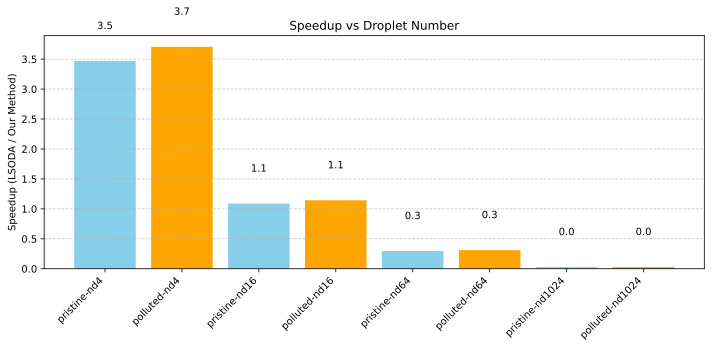

In [20]:
labels = list(speedup.keys())
values = [speedup[k] for k in labels]

pyplot.figure(figsize=(10,5))
colors = ['skyblue' if 'pristine' in l else 'orange' for l in labels]
bars = pyplot.bar(labels, values, color=colors)

pyplot.ylabel("Speedup (LSODA / Our Method)")
pyplot.title("Speedup vs Droplet Number")
pyplot.xticks(rotation=45, ha='right')
pyplot.grid(axis='y', linestyle='--', alpha=0.7)


for bar, val in zip(bars, values):
    pyplot.text(bar.get_x() + bar.get_width()/2, val + 0.5, f"{val:.1f}", ha='center', va='bottom')

pyplot.tight_layout()
show_plot('speedup')

TODO:
- adaptive ODE solver
- plots for different tolerances
- time vs. number of droplets scaling plot
- color-scale dt_adapt
- tolerances in SciPy solver
- comparison for different size attributes (time efficiency, accuracy)
- Numba threading
- thermo triplet arrays!
- switch thd to rh in adapt substeps

IDEAS:
- Jacobian
- isotopes